# Data Quality Expectations Development Notebook

The purpose of this notebook is to interactively identify data quality expectations for the raw and cleaned data input files.

Expectations that are true on the development dataset are written to an "expectations file" in JSON format, and the `great_expectations` package is used to validate that those expectations are met on future runs of the pipeline.  This helps avoid errors due to missing columns, inputs that don't meet your assumptions about data type (a common problem with pandas and python).  The goal is to get the pipeline to fail and tell you that something's wrong instead of running to completion and producing garbage output.

Use this notebook to develop accurate expectations about the input data.  You can add and adjust expectations over time.  Leave notes about why certain expectations are appropriate or adequate.

When you are done developing expectations, generate a final consistent expectations suite file by selecting "Restart & Run All" from the Kernal menu.  The notebook should run from beginning to end without errors.

Please write the expectations one per cell, and structure the cell to throw an error if the expectation fails.    Usually, this is accomplished with a command like `assert result.success`; otherwise, a failed expectation will not generate an error by default and will not be added to the expectation suite.


In [2]:
import datetime
import os
import re

import great_expectations as ge
import numpy as np
import pandas as pd
import rad_pipeline.rad_pipeline as rp
import rad_pipeline.zipcodes as zc
import rad_pipeline.summarize as rs

In [3]:
import importlib
importlib.reload(rp)
importlib.reload(zc)
importlib.reload(ge)
importlib.reload(rs)

<module 'rad_pipeline.summarize' from '/Users/alexhasha/repos/massenergize/rad_pipeline/rad_pipeline/summarize.py'>

In [4]:
EXPECTATIONS_DIR = "../data/expectations"

## ASHP

### Raw data expectations

In [4]:
ashp = ge.from_pandas(rp.load_ashp())

In [5]:
#Expect row count to increase in subsequent files
result = ashp.expect_table_row_count_to_be_between(19964, 30000)
assert result.success
print(result)

{
  "result": {
    "observed_value": 19964
  },
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "expectation_config": {
    "meta": {},
    "kwargs": {
      "min_value": 19964,
      "max_value": 30000,
      "result_format": "BASIC"
    },
    "expectation_type": "expect_table_row_count_to_be_between"
  },
  "meta": {},
  "success": true
}


In [6]:
field_map = rp.FIELDS['Air-source Heat Pumps']
for key_col in field_map:
    result = ashp.expect_column_to_exist(field_map[key_col])
    assert result.success
    print(result)

{
  "result": {},
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "expectation_config": {
    "meta": {},
    "kwargs": {
      "column": "Rebate Amount ",
      "result_format": "BASIC"
    },
    "expectation_type": "expect_column_to_exist"
  },
  "meta": {},
  "success": true
}
{
  "result": {},
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "expectation_config": {
    "meta": {},
    "kwargs": {
      "column": "Total System Costs",
      "result_format": "BASIC"
    },
    "expectation_type": "expect_column_to_exist"
  },
  "meta": {},
  "success": true
}
{
  "result": {},
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "expectation_config": {
    "meta": {},
    "kwargs": {
      "column": "Site Zip Code",
      "result_format": "BASIC"
    },
    "expectati

In [7]:
# Expect zipcode to be mostly numbers and mostly populated

In [8]:
result = ashp.expect_column_values_to_not_be_null(field_map['zip'])
assert result.success
print(result)

{
  "result": {
    "element_count": 19964,
    "unexpected_count": 0,
    "unexpected_percent": 0.0,
    "unexpected_percent_total": 0.0,
    "partial_unexpected_list": []
  },
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "expectation_config": {
    "meta": {},
    "kwargs": {
      "column": "Site Zip Code",
      "result_format": "BASIC"
    },
    "expectation_type": "expect_column_values_to_not_be_null"
  },
  "meta": {},
  "success": true
}


In [9]:
result = ashp.expect_column_values_to_be_in_type_list(field_map['zip'], ['int', 'float', 'str'])
assert result.success
print(result)

{
  "result": {
    "element_count": 19964,
    "missing_count": 0,
    "missing_percent": 0.0,
    "unexpected_count": 0,
    "unexpected_percent": 0.0,
    "unexpected_percent_total": 0.0,
    "unexpected_percent_nonmissing": 0.0,
    "partial_unexpected_list": []
  },
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "expectation_config": {
    "meta": {},
    "kwargs": {
      "column": "Site Zip Code",
      "type_list": [
        "int",
        "float",
        "str"
      ],
      "result_format": "BASIC"
    },
    "expectation_type": "_expect_column_values_to_be_in_type_list__map"
  },
  "meta": {},
  "success": true
}


In [10]:
result = ashp.expect_column_values_to_match_regex(field_map['zip'], r"^\s*([0-9]{3,5})(?:[.]0)?(?:-([0-9]{4})|-)?\s*$", mostly=0.98)
assert result.success
print(result)

{
  "result": {
    "element_count": 19964,
    "missing_count": 0,
    "missing_percent": 0.0,
    "unexpected_count": 3,
    "unexpected_percent": 0.015027048687637747,
    "unexpected_percent_total": 0.015027048687637747,
    "unexpected_percent_nonmissing": 0.015027048687637747,
    "partial_unexpected_list": [
      20,
      "019081047",
      "0212y"
    ]
  },
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "expectation_config": {
    "meta": {},
    "kwargs": {
      "column": "Site Zip Code",
      "regex": "^\\s*([0-9]{3,5})(?:[.]0)?(?:-([0-9]{4})|-)?\\s*$",
      "mostly": 0.98,
      "result_format": "BASIC"
    },
    "expectation_type": "expect_column_values_to_match_regex"
  },
  "meta": {},
  "success": true
}


In [11]:
# Expect rebate and cost to be mostly numbers

In [12]:
result = ashp.expect_column_values_to_be_in_type_list(field_map['rebate'], ['int', 'float'], mostly=0.99)
assert result.success
print(result)

{
  "result": {
    "element_count": 19964,
    "missing_count": 0,
    "missing_percent": 0.0,
    "unexpected_count": 1,
    "unexpected_percent": 0.005009016229212583,
    "unexpected_percent_total": 0.005009016229212583,
    "unexpected_percent_nonmissing": 0.005009016229212583,
    "partial_unexpected_list": [
      "Not Applicable"
    ]
  },
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "expectation_config": {
    "meta": {},
    "kwargs": {
      "column": "Rebate Amount ",
      "type_list": [
        "int",
        "float"
      ],
      "mostly": 0.99,
      "result_format": "BASIC"
    },
    "expectation_type": "_expect_column_values_to_be_in_type_list__map"
  },
  "meta": {},
  "success": true
}


In [13]:
result = ashp.expect_column_values_to_be_in_type_list(field_map['cost'], ['int', 'float'], mostly=0.99)
assert result.success
print(result)

{
  "result": {
    "element_count": 19964,
    "missing_count": 0,
    "missing_percent": 0.0,
    "unexpected_count": 19,
    "unexpected_percent": 0.09517130835503908,
    "unexpected_percent_total": 0.09517130835503908,
    "unexpected_percent_nonmissing": 0.09517130835503908,
    "partial_unexpected_list": [
      "1000-labor only",
      "1200-labor only",
      "31900-with boiler",
      "925-labor only",
      "18668.75-with 5C42 unit",
      "1000-labor only",
      "25490-with Bosch",
      "57814.74-with Trane",
      "22725-with Lennox equip",
      "17800-with other ac system",
      "903.01-labor only",
      "425-labor only",
      "12330-with Lennox thing",
      "53000-with furnace ",
      "30500-with Luxiare equip",
      "25091-with Carrier equip",
      "41430-with additional multi head",
      " $ 9000.00",
      "$19.524.15"
    ]
  },
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "expec

In [14]:
result = ashp.expect_column_values_to_be_of_type(field_map["date"], "datetime64")
assert result.success
print(result)

{
  "result": {
    "observed_value": "datetime64"
  },
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "expectation_config": {
    "meta": {},
    "kwargs": {
      "column": "Date Rebate Payment Approved by MassCEC",
      "type_": "datetime64",
      "result_format": "BASIC"
    },
    "expectation_type": "_expect_column_values_to_be_of_type__aggregate"
  },
  "meta": {},
  "success": true
}


In [15]:
result = ashp.expect_column_values_to_be_between(field_map["date"], 
                                                    ashp[field_map["date"]].min(), 
                                                    pd.Timestamp.now(),
                                                    parse_strings_as_datetimes=True)
assert result.success
print(result)

{
  "result": {
    "element_count": 19964,
    "missing_count": 0,
    "missing_percent": 0.0,
    "unexpected_count": 0,
    "unexpected_percent": 0.0,
    "unexpected_percent_total": 0.0,
    "unexpected_percent_nonmissing": 0.0,
    "partial_unexpected_list": []
  },
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "expectation_config": {
    "meta": {},
    "kwargs": {
      "column": "Date Rebate Payment Approved by MassCEC",
      "min_value": "2014-12-26 00:00:00",
      "max_value": "2021-07-19 22:51:31.583968",
      "parse_strings_as_datetimes": true,
      "result_format": "BASIC"
    },
    "expectation_type": "expect_column_values_to_be_between"
  },
  "meta": {},
  "success": true
}


In [16]:
ashp.save_expectation_suite("../data/expectations/ashp_raw_expectations.json")

In [17]:
validation_results = ashp.validate(expectation_suite="../data/expectations/ashp_raw_expectations.json", catch_exceptions=False)

### Clean data expectations

In [18]:
ashp_cleaned = ge.from_pandas(rp.clean_data_load("Air-source Heat Pumps"))

In [19]:
ashp_cleaned.shape[0] / ashp.shape[0]

0.9445001001803246

In [20]:
# Check that we have dropped no more than 7% of data
result = ashp_cleaned.expect_table_row_count_to_be_between(int(0.93*ashp.shape[0]), ashp.shape[0])  
assert result.success
print(result)

{
  "result": {
    "observed_value": 18856
  },
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "expectation_config": {
    "meta": {},
    "kwargs": {
      "min_value": 18566,
      "max_value": 19964,
      "result_format": "BASIC"
    },
    "expectation_type": "expect_table_row_count_to_be_between"
  },
  "meta": {},
  "success": true
}


In [21]:
result = ashp_cleaned.expect_column_to_exist("town_valid")
assert result.success
print(result)

{
  "result": {},
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "expectation_config": {
    "meta": {},
    "kwargs": {
      "column": "town_valid",
      "result_format": "BASIC"
    },
    "expectation_type": "expect_column_to_exist"
  },
  "meta": {},
  "success": true
}


In [22]:
result = ashp_cleaned.expect_column_to_exist("rebate")
assert result.success
print(result)

{
  "result": {},
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "expectation_config": {
    "meta": {},
    "kwargs": {
      "column": "rebate",
      "result_format": "BASIC"
    },
    "expectation_type": "expect_column_to_exist"
  },
  "meta": {},
  "success": true
}


In [23]:
result = ashp_cleaned.expect_column_to_exist("cost")
assert result.success
print(result)

{
  "result": {},
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "expectation_config": {
    "meta": {},
    "kwargs": {
      "column": "cost",
      "result_format": "BASIC"
    },
    "expectation_type": "expect_column_to_exist"
  },
  "meta": {},
  "success": true
}


In [24]:
result = ashp_cleaned.expect_column_values_to_be_in_set("town_valid", [True])
assert result.success
print(result)

{
  "result": {
    "element_count": 18856,
    "missing_count": 0,
    "missing_percent": 0.0,
    "unexpected_count": 0,
    "unexpected_percent": 0.0,
    "unexpected_percent_total": 0.0,
    "unexpected_percent_nonmissing": 0.0,
    "partial_unexpected_list": []
  },
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "expectation_config": {
    "meta": {},
    "kwargs": {
      "column": "town_valid",
      "value_set": [
        true
      ],
      "result_format": "BASIC"
    },
    "expectation_type": "expect_column_values_to_be_in_set"
  },
  "meta": {},
  "success": true
}


In [25]:
result = ashp_cleaned.expect_column_values_to_be_of_type("cost", "float")
assert result.success
print(result)

{
  "result": {
    "observed_value": "float64"
  },
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "expectation_config": {
    "meta": {},
    "kwargs": {
      "column": "cost",
      "type_": "float",
      "result_format": "BASIC"
    },
    "expectation_type": "_expect_column_values_to_be_of_type__aggregate"
  },
  "meta": {},
  "success": true
}


In [26]:
result = ashp_cleaned.expect_column_values_to_be_of_type("rebate", "float")
assert result.success
print(result)

{
  "result": {
    "observed_value": "float64"
  },
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "expectation_config": {
    "meta": {},
    "kwargs": {
      "column": "rebate",
      "type_": "float",
      "result_format": "BASIC"
    },
    "expectation_type": "_expect_column_values_to_be_of_type__aggregate"
  },
  "meta": {},
  "success": true
}


In [27]:
ashp_cleaned.save_expectation_suite("../data/expectations/ashp_clean_expectations.json")


## GSHP

In [28]:
gshp = ge.from_pandas(rp.load_gshp())

In [29]:
#Expect row count to increase in subsequent files
result = gshp.expect_table_row_count_to_be_between(538, 1000)
assert result.success
print(result)

{
  "result": {
    "observed_value": 538
  },
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "expectation_config": {
    "meta": {},
    "kwargs": {
      "min_value": 538,
      "max_value": 1000,
      "result_format": "BASIC"
    },
    "expectation_type": "expect_table_row_count_to_be_between"
  },
  "meta": {},
  "success": true
}


In [30]:
field_map = rp.FIELDS['Ground-source Heat Pumps']
for key_col in field_map:
    result = gshp.expect_column_to_exist(field_map[key_col])
    assert result.success
    print(result)

{
  "result": {},
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "expectation_config": {
    "meta": {},
    "kwargs": {
      "column": "Rebate Amount",
      "result_format": "BASIC"
    },
    "expectation_type": "expect_column_to_exist"
  },
  "meta": {},
  "success": true
}
{
  "result": {},
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "expectation_config": {
    "meta": {},
    "kwargs": {
      "column": "Total System Cost",
      "result_format": "BASIC"
    },
    "expectation_type": "expect_column_to_exist"
  },
  "meta": {},
  "success": true
}
{
  "result": {},
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "expectation_config": {
    "meta": {},
    "kwargs": {
      "column": "Site City/Town",
      "result_format": "BASIC"
    },
    "expectatio

In [31]:
result = gshp.expect_column_values_to_be_in_type_list(field_map['rebate'], ['int', 'float'], mostly=0.99)
assert result.success
print(result)

{
  "result": {
    "element_count": 538,
    "missing_count": 0,
    "missing_percent": 0.0,
    "unexpected_count": 2,
    "unexpected_percent": 0.37174721189591076,
    "unexpected_percent_total": 0.37174721189591076,
    "unexpected_percent_nonmissing": 0.37174721189591076,
    "partial_unexpected_list": [
      "$10000.00",
      "$10000.00"
    ]
  },
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "expectation_config": {
    "meta": {},
    "kwargs": {
      "column": "Rebate Amount",
      "type_list": [
        "int",
        "float"
      ],
      "mostly": 0.99,
      "result_format": "BASIC"
    },
    "expectation_type": "_expect_column_values_to_be_in_type_list__map"
  },
  "meta": {},
  "success": true
}


In [32]:
result = gshp.expect_column_values_to_be_in_type_list(field_map['cost'], ['int', 'float'], mostly=0.99)
assert result.success
print(result)

{
  "result": {
    "element_count": 538,
    "missing_count": 0,
    "missing_percent": 0.0,
    "unexpected_count": 3,
    "unexpected_percent": 0.5576208178438662,
    "unexpected_percent_total": 0.5576208178438662,
    "unexpected_percent_nonmissing": 0.5576208178438662,
    "partial_unexpected_list": [
      "$117910",
      "$81355",
      "$40445"
    ]
  },
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "expectation_config": {
    "meta": {},
    "kwargs": {
      "column": "Total System Cost",
      "type_list": [
        "int",
        "float"
      ],
      "mostly": 0.99,
      "result_format": "BASIC"
    },
    "expectation_type": "_expect_column_values_to_be_in_type_list__map"
  },
  "meta": {},
  "success": true
}


In [33]:
gshp.expect_column_values_to_be_between(field_map["date"], 
                                        gshp[field_map["date"]].min(), 
                                        pd.Timestamp.now(),
                                        parse_strings_as_datetimes=True)

{
  "result": {
    "element_count": 538,
    "missing_count": 0,
    "missing_percent": 0.0,
    "unexpected_count": 0,
    "unexpected_percent": 0.0,
    "unexpected_percent_total": 0.0,
    "unexpected_percent_nonmissing": 0.0,
    "partial_unexpected_list": []
  },
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "meta": {},
  "success": true
}

In [34]:
gshp.save_expectation_suite("../data/expectations/gshp_raw_expectations.json")

### Clean data expectations

In [35]:
gshp_cleaned = ge.from_pandas(rp.clean_data_load("Ground-source Heat Pumps"))

gshp_cleaned.shape[0] / gshp.shape[0]

0.9609665427509294

In [36]:
# Check that we have dropped no more than 5% of data
result = gshp_cleaned.expect_table_row_count_to_be_between(int(0.95*gshp.shape[0]), gshp.shape[0])  
assert result.success
print(result)

{
  "result": {
    "observed_value": 517
  },
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "expectation_config": {
    "meta": {},
    "kwargs": {
      "min_value": 511,
      "max_value": 538,
      "result_format": "BASIC"
    },
    "expectation_type": "expect_table_row_count_to_be_between"
  },
  "meta": {},
  "success": true
}


In [37]:
result = gshp_cleaned.expect_column_to_exist("town_valid")
print(result)
assert result.success


{
  "result": {},
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "expectation_config": {
    "meta": {},
    "kwargs": {
      "column": "town_valid",
      "result_format": "BASIC"
    },
    "expectation_type": "expect_column_to_exist"
  },
  "meta": {},
  "success": true
}


In [38]:
gshp_cleaned.columns

Index(['Rebate Approved by MassCEC', 'Site City/Town', 'Installer Name',
       'Driller Company', 'Primary Heating Fuel Prior to Installation',
       'Secondary Heating Fuel', 'Building Size (Square Feet)',
       'Previous Heat Distribution', 'Manual J Heat Load',
       'Heat Pump Function', 'Pump type', 'Loop Config.',
       'New Heating Distribution', 'Number of Bore Holes',
       'Total Bore Hole Depth (ft)', 'Peak Flow Rate (gallons per minute)',
       'HP Manufacturer', 'HP 1 Model', 'COP 1', 'EER 1',
       'Heating Capacity 1 (BTU/hr)', 'HP 2 Model', 'COP 2', 'EER 2',
       'Heating Capacity 2 (BTU/hr)', 'HP 3 Model', 'COP 3', 'EER 3',
       'Heating Capacity 3 (BTU/hr)', 'Total Capacity (BTU/hr)',
       'Eligible Capacity (BTU/hr) (maximum of 60,000 BTU/hr)',
       'Backup Source', 'Heat Pump Costs (Equip + Install) ',
       'Loop Cost (Equip + Install) ', 'Total System Cost', 'Rebate Amount',
       'Income-Based Rebate Received?', 'town', 'zip_exists', 'zip_cleane

In [39]:
result = gshp_cleaned.expect_column_to_exist("rebate")
print(result)
assert result.success

{
  "result": {},
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "expectation_config": {
    "meta": {},
    "kwargs": {
      "column": "rebate",
      "result_format": "BASIC"
    },
    "expectation_type": "expect_column_to_exist"
  },
  "meta": {},
  "success": true
}


In [40]:
result = gshp_cleaned.expect_column_to_exist("cost")
print(result)
assert result.success

{
  "result": {},
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "expectation_config": {
    "meta": {},
    "kwargs": {
      "column": "cost",
      "result_format": "BASIC"
    },
    "expectation_type": "expect_column_to_exist"
  },
  "meta": {},
  "success": true
}


In [41]:
result = gshp_cleaned.expect_column_values_to_be_in_set("town_valid", [True])
print(result)
assert result.success


{
  "result": {
    "element_count": 517,
    "missing_count": 0,
    "missing_percent": 0.0,
    "unexpected_count": 0,
    "unexpected_percent": 0.0,
    "unexpected_percent_total": 0.0,
    "unexpected_percent_nonmissing": 0.0,
    "partial_unexpected_list": []
  },
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "expectation_config": {
    "meta": {},
    "kwargs": {
      "column": "town_valid",
      "value_set": [
        true
      ],
      "result_format": "BASIC"
    },
    "expectation_type": "expect_column_values_to_be_in_set"
  },
  "meta": {},
  "success": true
}


In [42]:
result = gshp_cleaned.expect_column_values_to_be_of_type("cost", "float")
print(result)
assert result.success


{
  "result": {
    "observed_value": "float64"
  },
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "expectation_config": {
    "meta": {},
    "kwargs": {
      "column": "cost",
      "type_": "float",
      "result_format": "BASIC"
    },
    "expectation_type": "_expect_column_values_to_be_of_type__aggregate"
  },
  "meta": {},
  "success": true
}


In [43]:
result = gshp_cleaned.expect_column_values_to_be_of_type("rebate", "float")
print(result)
assert result.success


{
  "result": {
    "observed_value": "float64"
  },
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "expectation_config": {
    "meta": {},
    "kwargs": {
      "column": "rebate",
      "type_": "float",
      "result_format": "BASIC"
    },
    "expectation_type": "_expect_column_values_to_be_of_type__aggregate"
  },
  "meta": {},
  "success": true
}


In [44]:
gshp_cleaned.save_expectation_suite("../data/expectations/gshp_clean_expectations.json")

## Solar

### Raw data expectations

In [45]:
solar = ge.from_pandas(rp.load_solar())

In [46]:
#Expect row count to increase in subsequent files
result = solar.expect_table_row_count_to_be_between(90141, 200000)
print(result)
assert result.success

{
  "result": {
    "observed_value": 90141
  },
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "expectation_config": {
    "meta": {},
    "kwargs": {
      "min_value": 90141,
      "max_value": 200000,
      "result_format": "BASIC"
    },
    "expectation_type": "expect_table_row_count_to_be_between"
  },
  "meta": {},
  "success": true
}


In [47]:
field_map = rp.FIELDS['Solar Panels']
for key_col in field_map:
    result = solar.expect_column_to_exist(field_map[key_col])
    print(result)
    assert result.success
 

{
  "result": {},
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "expectation_config": {
    "meta": {},
    "kwargs": {
      "column": "Total Cost with Design Fees",
      "result_format": "BASIC"
    },
    "expectation_type": "expect_column_to_exist"
  },
  "meta": {},
  "success": true
}
{
  "result": {},
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "expectation_config": {
    "meta": {},
    "kwargs": {
      "column": "Zip",
      "result_format": "BASIC"
    },
    "expectation_type": "expect_column_to_exist"
  },
  "meta": {},
  "success": true
}
{
  "result": {},
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "expectation_config": {
    "meta": {},
    "kwargs": {
      "column": "Facility Type",
      "result_format": "BASIC"
    },
    "expectation

In [48]:
# Expect zipcode to be mostly numbers and mostly populated

result = solar.expect_column_values_to_not_be_null(field_map['zip'])
print(result)
assert result.success

{
  "result": {
    "element_count": 90141,
    "unexpected_count": 0,
    "unexpected_percent": 0.0,
    "unexpected_percent_total": 0.0,
    "partial_unexpected_list": []
  },
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "expectation_config": {
    "meta": {},
    "kwargs": {
      "column": "Zip",
      "result_format": "BASIC"
    },
    "expectation_type": "expect_column_values_to_not_be_null"
  },
  "meta": {},
  "success": true
}


In [49]:
result = solar.expect_column_values_to_be_in_type_list(field_map['zip'], ['int', 'float', 'str'])
print(result)
assert result.success

{
  "result": {
    "observed_value": "int64"
  },
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "expectation_config": {
    "meta": {},
    "kwargs": {
      "column": "Zip",
      "type_list": [
        "int",
        "float",
        "str"
      ],
      "result_format": "BASIC"
    },
    "expectation_type": "_expect_column_values_to_be_in_type_list__aggregate"
  },
  "meta": {},
  "success": true
}


In [50]:
result = solar.expect_column_values_to_match_regex(field_map['zip'], r"^\s*([0-9]{3,5})(?:[.]0)?(?:-([0-9]{4})|-)?\s*$")
print(result)
assert result.success

{
  "result": {
    "element_count": 90141,
    "missing_count": 0,
    "missing_percent": 0.0,
    "unexpected_count": 0,
    "unexpected_percent": 0.0,
    "unexpected_percent_total": 0.0,
    "unexpected_percent_nonmissing": 0.0,
    "partial_unexpected_list": []
  },
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "expectation_config": {
    "meta": {},
    "kwargs": {
      "column": "Zip",
      "regex": "^\\s*([0-9]{3,5})(?:[.]0)?(?:-([0-9]{4})|-)?\\s*$",
      "result_format": "BASIC"
    },
    "expectation_type": "expect_column_values_to_match_regex"
  },
  "meta": {},
  "success": true
}


In [51]:
# Expect capacity and cost to be mostly numbers

result = solar.expect_column_values_to_be_in_type_list(field_map['capacity'], ['int', 'float'])
print(result)
assert result.success

{
  "result": {
    "observed_value": "float64"
  },
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "expectation_config": {
    "meta": {},
    "kwargs": {
      "column": "Capacity \n(DC, kW)",
      "type_list": [
        "int",
        "float"
      ],
      "result_format": "BASIC"
    },
    "expectation_type": "_expect_column_values_to_be_in_type_list__aggregate"
  },
  "meta": {},
  "success": true
}


In [52]:
result = solar.expect_column_values_to_be_in_type_list(field_map['cost'], ['int', 'float'])
print(result)
assert result.success

{
  "result": {
    "observed_value": "float64"
  },
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "expectation_config": {
    "meta": {},
    "kwargs": {
      "column": "Total Cost with Design Fees",
      "type_list": [
        "int",
        "float"
      ],
      "result_format": "BASIC"
    },
    "expectation_type": "_expect_column_values_to_be_in_type_list__aggregate"
  },
  "meta": {},
  "success": true
}


In [53]:
result = solar.expect_column_values_to_be_of_type(field_map["date"], "datetime64")
print(result)
assert result.success

{
  "result": {
    "observed_value": "datetime64"
  },
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "expectation_config": {
    "meta": {},
    "kwargs": {
      "column": "Date In Service",
      "type_": "datetime64",
      "result_format": "BASIC"
    },
    "expectation_type": "_expect_column_values_to_be_of_type__aggregate"
  },
  "meta": {},
  "success": true
}


<AxesSubplot:>

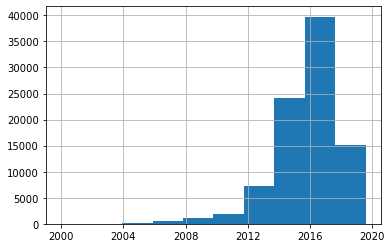

In [54]:
solar[field_map["date"]].hist()

In [55]:
result = solar.expect_column_values_to_be_between(field_map["date"], 
                                                    solar[field_map["date"]].min(), 
                                                    pd.Timestamp.now(),
                                                    parse_strings_as_datetimes=True)
print(result)
assert result.success

{
  "result": {
    "element_count": 90141,
    "missing_count": 101,
    "missing_percent": 0.11204668241976459,
    "unexpected_count": 0,
    "unexpected_percent": 0.0,
    "unexpected_percent_total": 0.0,
    "unexpected_percent_nonmissing": 0.0,
    "partial_unexpected_list": []
  },
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "expectation_config": {
    "meta": {},
    "kwargs": {
      "column": "Date In Service",
      "min_value": "2000-01-01 00:00:00",
      "max_value": "2021-07-19 22:52:04.478823",
      "parse_strings_as_datetimes": true,
      "result_format": "BASIC"
    },
    "expectation_type": "expect_column_values_to_be_between"
  },
  "meta": {},
  "success": true
}


In [56]:
solar.save_expectation_suite("../data/expectations/solar_raw_expectations.json")

In [57]:
validation_results = solar.validate(expectation_suite="../data/expectations/solar_raw_expectations.json", catch_exceptions=False)

### Clean data expectations

In [58]:
solar_cleaned = ge.from_pandas(rp.clean_data_load("Solar Panels"))

In [59]:
solar_cleaned.shape[0] / solar.shape[0]

0.9246735669673067

In [60]:
# Check that we have dropped no more than 7% of data
result = solar_cleaned.expect_table_row_count_to_be_between(int(0.91*solar.shape[0]), solar.shape[0])  
print(result)
assert result.success

{
  "result": {
    "observed_value": 83351
  },
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "expectation_config": {
    "meta": {},
    "kwargs": {
      "min_value": 82028,
      "max_value": 90141,
      "result_format": "BASIC"
    },
    "expectation_type": "expect_table_row_count_to_be_between"
  },
  "meta": {},
  "success": true
}


In [61]:
result = solar_cleaned.expect_column_to_exist("town_valid")
print(result)
assert result.success

{
  "result": {},
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "expectation_config": {
    "meta": {},
    "kwargs": {
      "column": "town_valid",
      "result_format": "BASIC"
    },
    "expectation_type": "expect_column_to_exist"
  },
  "meta": {},
  "success": true
}


In [62]:
result = solar_cleaned.expect_column_to_exist("cost")
print(result)
assert result.success

{
  "result": {},
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "expectation_config": {
    "meta": {},
    "kwargs": {
      "column": "cost",
      "result_format": "BASIC"
    },
    "expectation_type": "expect_column_to_exist"
  },
  "meta": {},
  "success": true
}


In [63]:
result = solar_cleaned.expect_column_to_exist("capacity")
print(result)
assert result.success

{
  "result": {},
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "expectation_config": {
    "meta": {},
    "kwargs": {
      "column": "capacity",
      "result_format": "BASIC"
    },
    "expectation_type": "expect_column_to_exist"
  },
  "meta": {},
  "success": true
}


In [64]:
result = solar_cleaned.expect_column_values_to_be_in_set("town_valid", [True])
print(result)
assert result.success


{
  "result": {
    "element_count": 83351,
    "missing_count": 0,
    "missing_percent": 0.0,
    "unexpected_count": 0,
    "unexpected_percent": 0.0,
    "unexpected_percent_total": 0.0,
    "unexpected_percent_nonmissing": 0.0,
    "partial_unexpected_list": []
  },
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "expectation_config": {
    "meta": {},
    "kwargs": {
      "column": "town_valid",
      "value_set": [
        true
      ],
      "result_format": "BASIC"
    },
    "expectation_type": "expect_column_values_to_be_in_set"
  },
  "meta": {},
  "success": true
}


In [65]:
result = solar_cleaned.expect_column_values_to_be_of_type("cost", "float")
print(result)
assert result.success


{
  "result": {
    "observed_value": "float64"
  },
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "expectation_config": {
    "meta": {},
    "kwargs": {
      "column": "cost",
      "type_": "float",
      "result_format": "BASIC"
    },
    "expectation_type": "_expect_column_values_to_be_of_type__aggregate"
  },
  "meta": {},
  "success": true
}


In [66]:
result = solar_cleaned.expect_column_values_to_be_of_type("capacity", "float")
print(result)
assert result.success


{
  "result": {
    "observed_value": "float64"
  },
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "expectation_config": {
    "meta": {},
    "kwargs": {
      "column": "capacity",
      "type_": "float",
      "result_format": "BASIC"
    },
    "expectation_type": "_expect_column_values_to_be_of_type__aggregate"
  },
  "meta": {},
  "success": true
}


In [67]:
solar_cleaned.save_expectation_suite("../data/expectations/solar_clean_expectations.json")

## Electric Vehicles (EVs)

### Raw data expectations

In [68]:
evs = ge.from_pandas(rp.load_evs())

In [69]:
#Expect row count to increase in subsequent files
result = evs.expect_table_row_count_to_be_between(18632, 30000)
print(result)
assert result.success

{
  "result": {
    "observed_value": 18632
  },
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "expectation_config": {
    "meta": {},
    "kwargs": {
      "min_value": 18632,
      "max_value": 30000,
      "result_format": "BASIC"
    },
    "expectation_type": "expect_table_row_count_to_be_between"
  },
  "meta": {},
  "success": true
}


In [70]:
field_map = rp.FIELDS['EVs']
for key_col in field_map:
    result = evs.expect_column_to_exist(field_map[key_col])
    print(result)
    assert result.success

{
  "result": {},
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "expectation_config": {
    "meta": {},
    "kwargs": {
      "column": "Total Amount",
      "result_format": "BASIC"
    },
    "expectation_type": "expect_column_to_exist"
  },
  "meta": {},
  "success": true
}
{
  "result": {},
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "expectation_config": {
    "meta": {},
    "kwargs": {
      "column": "Zip Code",
      "result_format": "BASIC"
    },
    "expectation_type": "expect_column_to_exist"
  },
  "meta": {},
  "success": true
}
{
  "result": {},
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "expectation_config": {
    "meta": {},
    "kwargs": {
      "column": "County",
      "result_format": "BASIC"
    },
    "expectation_type": "expect_c

In [71]:
# Expect zipcode to be mostly numbers and mostly populated
result = evs.expect_column_values_to_not_be_null(field_map['zip'])
print(result)
assert result.success

{
  "result": {
    "element_count": 18632,
    "unexpected_count": 0,
    "unexpected_percent": 0.0,
    "unexpected_percent_total": 0.0,
    "partial_unexpected_list": []
  },
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "expectation_config": {
    "meta": {},
    "kwargs": {
      "column": "Zip Code",
      "result_format": "BASIC"
    },
    "expectation_type": "expect_column_values_to_not_be_null"
  },
  "meta": {},
  "success": true
}


In [72]:
result = evs.expect_column_values_to_be_in_type_list(field_map['zip'], ['int', 'float', 'str'])
print(result)
assert result.success

{
  "result": {
    "observed_value": "int64"
  },
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "expectation_config": {
    "meta": {},
    "kwargs": {
      "column": "Zip Code",
      "type_list": [
        "int",
        "float",
        "str"
      ],
      "result_format": "BASIC"
    },
    "expectation_type": "_expect_column_values_to_be_in_type_list__aggregate"
  },
  "meta": {},
  "success": true
}


In [73]:
result = evs.expect_column_values_to_match_regex(field_map['zip'], r"^\s*([0-9]{3,5})(?:[.]0)?(?:-([0-9]{4})|-)?\s*$")
print(result)
assert result.success

{
  "result": {
    "element_count": 18632,
    "missing_count": 0,
    "missing_percent": 0.0,
    "unexpected_count": 0,
    "unexpected_percent": 0.0,
    "unexpected_percent_total": 0.0,
    "unexpected_percent_nonmissing": 0.0,
    "partial_unexpected_list": []
  },
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "expectation_config": {
    "meta": {},
    "kwargs": {
      "column": "Zip Code",
      "regex": "^\\s*([0-9]{3,5})(?:[.]0)?(?:-([0-9]{4})|-)?\\s*$",
      "result_format": "BASIC"
    },
    "expectation_type": "expect_column_values_to_match_regex"
  },
  "meta": {},
  "success": true
}


In [74]:
# Expect rebate to be mostly numbers
result = evs.expect_column_values_to_be_in_type_list(field_map['rebate'], ['int', 'float'])
print(result)
assert result.success

{
  "result": {
    "observed_value": "int64"
  },
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "expectation_config": {
    "meta": {},
    "kwargs": {
      "column": "Total Amount",
      "type_list": [
        "int",
        "float"
      ],
      "result_format": "BASIC"
    },
    "expectation_type": "_expect_column_values_to_be_in_type_list__aggregate"
  },
  "meta": {},
  "success": true
}


In [75]:
result = evs.expect_column_values_to_be_of_type(field_map["date"], "datetime64")
print(result)
assert result.success

{
  "result": {
    "observed_value": "datetime64"
  },
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "expectation_config": {
    "meta": {},
    "kwargs": {
      "column": "Date of Purchase",
      "type_": "datetime64",
      "result_format": "BASIC"
    },
    "expectation_type": "_expect_column_values_to_be_of_type__aggregate"
  },
  "meta": {},
  "success": true
}


{
  "result": {
    "element_count": 18632,
    "missing_count": 0,
    "missing_percent": 0.0,
    "unexpected_count": 0,
    "unexpected_percent": 0.0,
    "unexpected_percent_total": 0.0,
    "unexpected_percent_nonmissing": 0.0,
    "partial_unexpected_list": []
  },
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "expectation_config": {
    "meta": {},
    "kwargs": {
      "column": "Date of Purchase",
      "min_value": "2014-06-18 00:00:00",
      "max_value": "2021-07-19 22:52:13.429729",
      "parse_strings_as_datetimes": true,
      "result_format": "BASIC"
    },
    "expectation_type": "expect_column_values_to_be_between"
  },
  "meta": {},
  "success": true
}


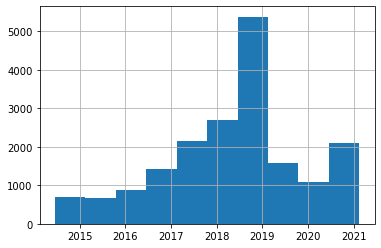

In [76]:
evs[field_map["date"]].hist()

result = evs.expect_column_values_to_be_between(field_map["date"], 
                                                    evs[field_map["date"]].min(), 
                                                    pd.Timestamp.now(),
                                                    parse_strings_as_datetimes=True)
print(result)
assert result.success

In [77]:
evs.save_expectation_suite("../data/expectations/evs_raw_expectations.json")

In [78]:
validation_results = evs.validate(expectation_suite="../data/expectations/evs_raw_expectations.json", catch_exceptions=False)

### Clean data expectations

In [79]:
evs_cleaned = ge.from_pandas(rp.clean_data_load("EVs"))

In [80]:
evs_cleaned.shape[0] / evs.shape[0]

1.0

In [81]:
# Check that we have dropped no more than 1% of data
result = evs_cleaned.expect_table_row_count_to_be_between(int(0.99*evs.shape[0]), evs.shape[0])  
print(result)
assert result.success

{
  "result": {
    "observed_value": 18632
  },
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "expectation_config": {
    "meta": {},
    "kwargs": {
      "min_value": 18445,
      "max_value": 18632,
      "result_format": "BASIC"
    },
    "expectation_type": "expect_table_row_count_to_be_between"
  },
  "meta": {},
  "success": true
}


In [82]:
result = evs_cleaned.expect_column_to_exist("town_valid")
print(result)
assert result.success

{
  "result": {},
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "expectation_config": {
    "meta": {},
    "kwargs": {
      "column": "town_valid",
      "result_format": "BASIC"
    },
    "expectation_type": "expect_column_to_exist"
  },
  "meta": {},
  "success": true
}


In [83]:
result = evs_cleaned.expect_column_to_exist("zip_cleaned")
print(result)
assert result.success

{
  "result": {},
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "expectation_config": {
    "meta": {},
    "kwargs": {
      "column": "zip_cleaned",
      "result_format": "BASIC"
    },
    "expectation_type": "expect_column_to_exist"
  },
  "meta": {},
  "success": true
}


In [84]:
result = evs_cleaned.expect_column_to_exist("rebate")
print(result)
assert result.success

{
  "result": {},
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "expectation_config": {
    "meta": {},
    "kwargs": {
      "column": "rebate",
      "result_format": "BASIC"
    },
    "expectation_type": "expect_column_to_exist"
  },
  "meta": {},
  "success": true
}


In [85]:
result = evs_cleaned.expect_column_values_to_be_in_set("town_valid", [True])
print(result)
assert result.success

{
  "result": {
    "element_count": 18632,
    "missing_count": 0,
    "missing_percent": 0.0,
    "unexpected_count": 0,
    "unexpected_percent": 0.0,
    "unexpected_percent_total": 0.0,
    "unexpected_percent_nonmissing": 0.0,
    "partial_unexpected_list": []
  },
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "expectation_config": {
    "meta": {},
    "kwargs": {
      "column": "town_valid",
      "value_set": [
        true
      ],
      "result_format": "BASIC"
    },
    "expectation_type": "expect_column_values_to_be_in_set"
  },
  "meta": {},
  "success": true
}


In [86]:
result = evs_cleaned.expect_column_values_to_be_in_set("zip_valid", [True])
print(result)
assert result.success

{
  "result": {
    "element_count": 18632,
    "missing_count": 0,
    "missing_percent": 0.0,
    "unexpected_count": 0,
    "unexpected_percent": 0.0,
    "unexpected_percent_total": 0.0,
    "unexpected_percent_nonmissing": 0.0,
    "partial_unexpected_list": []
  },
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "expectation_config": {
    "meta": {},
    "kwargs": {
      "column": "zip_valid",
      "value_set": [
        true
      ],
      "result_format": "BASIC"
    },
    "expectation_type": "expect_column_values_to_be_in_set"
  },
  "meta": {},
  "success": true
}


In [87]:
result = evs_cleaned.expect_column_values_to_be_of_type("rebate", "int64")
print(result)
assert result.success

{
  "result": {
    "observed_value": "int64"
  },
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "expectation_config": {
    "meta": {},
    "kwargs": {
      "column": "rebate",
      "type_": "int64",
      "result_format": "BASIC"
    },
    "expectation_type": "_expect_column_values_to_be_of_type__aggregate"
  },
  "meta": {},
  "success": true
}


In [88]:
evs_cleaned.save_expectation_suite("../data/expectations/evs_clean_expectations.json")

# Zipcode data quality checks

1. Town names from the `zipcodes` package correspond to the "city" field of the 351 muni mapping file.  
2. All zipcodes in zipcode community map file correspond to at least one municipality
3. (Not true) ~~All 351 municipalities correspond to at least one zipcode in the map~~ Some small municipalities share a zipcode with other munipalities
4. 

In [89]:
zipcode_mapping = pd.read_excel(rp.RAW_DATA_FILES["zip_code_community"], sheet_name="Villages to Muni with Zip")

In [90]:
VALID_MUNIS = pd.read_excel(rp.RAW_DATA_FILES["zip_code_community"], sheet_name="351 Mass Munis")

In [91]:
zipcode_mapping.head()

,Zip Code,City,Municipality,County,Unnamed: 4,Unnamed: 5
0,1001,Agawam,Agawam,Hampden,NaN,NaN
1,1002,Amherst,Amherst,Hampshire,NaN,NaN
2,1003,Amherst,Amherst,Hampshire,NaN,NaN
3,1004,Amherst,Amherst,Hampshire,NaN,NaN
4,1005,Barre,Barre,Worcester,NaN,NaN


In [92]:
VALID_MUNIS.head()

,Municipality
0,Abington
1,Acton
2,Acushnet
3,Adams
4,Agawam


In [93]:
# Standardize zips into properly formatted strings
clean_zips = zc.clean(zipcode_mapping["Zip Code"])

In [94]:
zipcode_mapping["zip_cleaned"] = clean_zips.zip_cleaned

In [95]:
zc.validate_zip_town(zipcode_mapping, "City", "zip_cleaned")

,Zip Code,City,Municipality,County,Unnamed: 4,Unnamed: 5,zip_cleaned,municipality,town,zip_exists,town_valid
0,1001,Agawam,Agawam,Hampden,NaN,NaN,01001,Agawam,Agawam,True,True
1,1002,Amherst,Amherst,Hampshire,NaN,NaN,01002,Amherst,Amherst,True,True
2,1003,Amherst,Amherst,Hampshire,NaN,NaN,01003,Amherst,Amherst,True,True
3,1004,Amherst,Amherst,Hampshire,NaN,NaN,01004,Amherst,Amherst,True,True
4,1005,Barre,Barre,Worcester,NaN,NaN,01005,Barre,Barre,True,True
...,...,...,...,...,...,...,...,...,...,...,...
711,1237,New Ashford,New Ashford,Berkshire,NaN,NaN,01237,New Ashford,Lanesboro,True,True
712,1002,Pelham,Pelham,Hampshire,NaN,NaN,01002,Pelham,Amherst,True,True
713,1331,Phillipston,Phillipston,Worcester,NaN,NaN,01331,Phillipston,Athol,True,True
714,1223,Washington,Washington,Berkshire,NaN,NaN,01223,Washington,Becket,True,True


In [96]:
import zipcodes
#zipcodes.filter_by(state="MA", city=list(zipcode_mapping[pd.isna(zipcode_mapping.zip_cleaned)]["Municipality"]))
munis_missing_zips = zipcode_mapping[pd.isna(zipcode_mapping.zip_cleaned)]["Municipality"]

In [97]:
for muni in munis_missing_zips:
    print(muni)

In [98]:
ma_zipcodes = zipcode_mapping[~pd.isna(zipcode_mapping.zip_cleaned)]["zip_cleaned"]

In [99]:
import itertools
muni_zip_map = {}
for zip in ma_zipcodes:
    zip_hits = zipcodes.matching(zip)
    alternative_towns = [(zip, ac, entry['county']) for entry in zip_hits for ac in entry['acceptable_cities']]
    if len(alternative_towns) > 0:
        print(alternative_towns)
       

[('01002', 'Cushman', 'Hampshire County'), ('01002', 'Pelham', 'Hampshire County')]
[('01013', 'Willimansett', 'Hampden County')]
[('01022', 'Westover Afb', 'Hampden County')]
[('01027', 'E Hampton', 'Hampshire County'), ('01027', 'Mount Tom', 'Hampshire County'), ('01027', 'Westhampton', 'Hampshire County')]
[('01028', 'E Longmeadow', 'Hampden County')]
[('01034', 'Tolland', 'Hampden County')]
[('01039', 'West Whately', 'Hampshire County')]
[('01050', 'Montgomery', 'Hampshire County')]
[('01059', 'Amherst', 'Hampshire County')]
[('01062', 'Bay State Village', 'Hampshire County'), ('01062', 'Bay State Vlg', 'Hampshire County'), ('01062', 'Northampton', 'Hampshire County')]
[('01066', 'N Hatfield', 'Hampshire County')]
[('01082', 'Hardwick', 'Hampshire County')]
[('01084', 'W Chesterfld', 'Hampshire County')]
[('01085', 'Montgomery', 'Hampden County')]
[('01088', 'W Hatfield', 'Hampshire County')]
[('01089', 'W Springfield', 'Hampden County')]
[('01090', 'W Springfield', 'Hampden County

In [100]:
zm_df = ge.from_pandas(zipcode_mapping)

In [101]:
zm_df.expect_column_distinct_values_to_equal_set("Municipality", list(VALID_MUNIS["Municipality"]))

{
  "result": {
    "observed_value": [
      "Abington",
      "Acton",
      "Acushnet",
      "Adams",
      "Agawam",
      "Alford",
      "Amesbury",
      "Amherst",
      "Andover",
      "Aquinnah",
      "Arlington",
      "Ashburnham",
      "Ashby",
      "Ashfield",
      "Ashland",
      "Athol",
      "Attleboro",
      "Auburn",
      "Avon",
      "Ayer",
      "Barnstable",
      "Barre",
      "Becket",
      "Bedford",
      "Belchertown",
      "Bellingham",
      "Belmont",
      "Berkley",
      "Berlin",
      "Bernardston",
      "Beverly",
      "Billerica",
      "Blackstone",
      "Blandford",
      "Bolton",
      "Boston",
      "Bourne",
      "Boxborough",
      "Boxford",
      "Boylston",
      "Braintree",
      "Brewster",
      "Bridgewater",
      "Brimfield",
      "Brockton",
      "Brookfield",
      "Brookline",
      "Buckland",
      "Burlington",
      "Cambridge",
      "Canton",
      "Carlisle",
      "Carver",
      "Charlemont",
      

# Output Data Quality Checks

In [5]:
summarized = ge.from_pandas(rs.load_summarized_metrics())

In [6]:
summarized.shape

(29539, 8)

In [7]:
result = summarized.expect_table_row_count_to_be_between(24000, 40000)  
print(result)
assert result.success

{
  "success": true,
  "expectation_config": {
    "expectation_type": "expect_table_row_count_to_be_between",
    "kwargs": {
      "min_value": 24000,
      "max_value": 40000,
      "result_format": "BASIC"
    },
    "meta": {}
  },
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "result": {
    "observed_value": 29539
  },
  "meta": {}
}


In [8]:
summarized.head()

,zipcodes,start_date,end_date,technology,sector,value_unit,metric_name,value
locale,,,,,,,,
Abington,[02351],2016-03-16,2019-04-10,Air-source Heat Pumps,Residential,count,Number of Rebates,23.0
Acton,"[01718, 01720]",2015-05-06,2019-05-08,Air-source Heat Pumps,Residential,count,Number of Rebates,131.0
Acushnet,[02743],2016-01-13,2019-06-26,Air-source Heat Pumps,Residential,count,Number of Rebates,44.0
Adams,[01220],2018-10-11,2018-10-11,Air-source Heat Pumps,Residential,count,Number of Rebates,1.0
Agawam,"[01001, 01030]",2015-01-15,2019-05-08,Air-source Heat Pumps,Residential,count,Number of Rebates,93.0


In [9]:
for column in ["zipcodes", "start_date", "end_date", "technology", "sector", "value_unit", "metric_name", "value"]:
    
    result = summarized.expect_column_to_exist(column)
    print(result)
    assert result.success

{
  "success": true,
  "expectation_config": {
    "expectation_type": "expect_column_to_exist",
    "kwargs": {
      "column": "zipcodes",
      "result_format": "BASIC"
    },
    "meta": {}
  },
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "result": {},
  "meta": {}
}
{
  "success": true,
  "expectation_config": {
    "expectation_type": "expect_column_to_exist",
    "kwargs": {
      "column": "start_date",
      "result_format": "BASIC"
    },
    "meta": {}
  },
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "result": {},
  "meta": {}
}
{
  "success": true,
  "expectation_config": {
    "expectation_type": "expect_column_to_exist",
    "kwargs": {
      "column": "end_date",
      "result_format": "BASIC"
    },
    "meta": {}
  },
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "except

In [10]:
result = summarized.expect_column_distinct_values_to_equal_set("technology", 
                                                      [
                                                          "Air-source Heat Pumps",
                                                          "Ground-source Heat Pumps",
                                                          "Solar Panels",
                                                          "EVs"
                                                      ])
print(result)
assert result.success

{
  "success": true,
  "expectation_config": {
    "expectation_type": "expect_column_distinct_values_to_equal_set",
    "kwargs": {
      "column": "technology",
      "value_set": [
        "Air-source Heat Pumps",
        "Ground-source Heat Pumps",
        "Solar Panels",
        "EVs"
      ],
      "result_format": "BASIC"
    },
    "meta": {}
  },
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "result": {
    "observed_value": [
      "Air-source Heat Pumps",
      "EVs",
      "Ground-source Heat Pumps",
      "Solar Panels"
    ],
    "element_count": 29539,
    "missing_count": null,
    "missing_percent": null
  },
  "meta": {}
}


In [11]:
result = summarized.expect_column_distinct_values_to_contain_set("metric_name",
                                                       [
                                                        'Number of Rebates', 
                                                        'Total Rebate Value', 
                                                        'Average Rebate Value',
                                                        'Total Cost',
                                                        'Average Cost',
                                                        'Number of generation facilities',
                                                        'Total Generation Capacity',
                                                        'Average Generation Capacity'
                                                       ])
print(result)
assert result.success

{
  "success": true,
  "expectation_config": {
    "expectation_type": "expect_column_distinct_values_to_contain_set",
    "kwargs": {
      "column": "metric_name",
      "value_set": [
        "Number of Rebates",
        "Total Rebate Value",
        "Average Rebate Value",
        "Total Cost",
        "Average Cost",
        "Number of generation facilities",
        "Total Generation Capacity",
        "Average Generation Capacity"
      ],
      "result_format": "BASIC"
    },
    "meta": {}
  },
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "result": {
    "observed_value": [
      "Average Cost",
      "Average Generation Capacity",
      "Average Rebate Value",
      "Number of Rebates",
      "Number of generation facilities",
      "Total Cost",
      "Total Generation Capacity",
      "Total Rebate Value"
    ],
    "element_count": 29539,
    "missing_count": null,
    "missing_percent": null
  }

In [12]:
result = summarized.expect_column_distinct_values_to_contain_set("sector",
                                                       ['Residential', 
                                                        'Residential and Small Scale', 
                                                        'Consumer', 
                                                        'All',
                                                        'Commercial / Office', 'Industrial',
                                                        'Multi-family residential (4 or more dwelling units per building)',
                                                        'Municipal - K-12 School', 'Other',
                                                        'Residential (3 or fewer dwelling units per building)', 'Retail',
                                                        'Agricultural', 'Municipal / Government / Public',
                                                        'Restaurant / Food Service', 'School (K-12)', 'State',
                                                        'Community Solar', 'College / University', 'Religious',
                                                        'Mixed use (commercial & residential)',
                                                        'State - College/University', 'Hospital / Health Care', 'Federal'
                                                       ])
print(result)
assert result.success

{
  "success": true,
  "expectation_config": {
    "expectation_type": "expect_column_distinct_values_to_contain_set",
    "kwargs": {
      "column": "sector",
      "value_set": [
        "Residential",
        "Residential and Small Scale",
        "Consumer",
        "All",
        "Commercial / Office",
        "Industrial",
        "Multi-family residential (4 or more dwelling units per building)",
        "Municipal - K-12 School",
        "Other",
        "Residential (3 or fewer dwelling units per building)",
        "Retail",
        "Agricultural",
        "Municipal / Government / Public",
        "Restaurant / Food Service",
        "School (K-12)",
        "State",
        "Community Solar",
        "College / University",
        "Religious",
        "Mixed use (commercial & residential)",
        "State - College/University",
        "Hospital / Health Care",
        "Federal"
      ],
      "result_format": "BASIC"
    },
    "meta": {}
  },
  "exception_info": {
    "

In [13]:
result = summarized.expect_column_values_to_be_of_type("value", "float64")
print(result)
assert result.success

{
  "success": true,
  "expectation_config": {
    "expectation_type": "_expect_column_values_to_be_of_type__aggregate",
    "kwargs": {
      "column": "value",
      "type_": "float64",
      "result_format": "BASIC"
    },
    "meta": {}
  },
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  },
  "result": {
    "observed_value": "float64"
  },
  "meta": {}
}


In [ ]:
summarized.expect_

In [22]:
len(summarized.index)

29539

In [31]:
munis = [muni for muni in summarized.index.unique() if not muni.isdigit()]

In [24]:
set(summarized.index.unique())

Index(['Abington', 'Acton', 'Acushnet', 'Adams', 'Agawam', 'Amesbury',
       'Amherst', 'Andover', 'Aquinnah', 'Arlington',
       ...
       '02269', '02303', '02325', '02334', '02361', '02454', '02541', '02714',
       '02722', '02783'],
      dtype='object', name='locale', length=1076)

In [25]:
VALID_MUNIS = pd.read_excel(rp.RAW_DATA_FILES["zip_code_community"], sheet_name="351 Mass Munis")

In [27]:
VALID_MUNIS['Municipality']

0         Abington
1            Acton
2         Acushnet
3            Adams
4           Agawam
          ...     
345         Woburn
346      Worcester
347    Worthington
348       Wrentham
349       Yarmouth
Name: Municipality, Length: 350, dtype: object

In [35]:
set(munis).difference(VALID_MUNIS['Municipality'])

{'',
 'Allston',
 'Ashley Falls',
 'Assonet',
 'Attleboro Falls',
 'Auburndale',
 'Baldwinville',
 'Bondsville',
 'Brighton',
 'Buzzards Bay',
 'Byfield',
 'Cataumet',
 'Centerville',
 'Charlestown',
 'Charlton City',
 'Charlton Depot',
 'Cherry Valley',
 'Chestnut Hill',
 'Cotuit',
 'Cummaquid',
 'Dennis Port',
 'Devens',
 'Dorchester',
 'Dorchester Center',
 'East Dennis',
 'East Falmouth',
 'East Freetown',
 'East Orleans',
 'East Otis',
 'East Sandwich',
 'East Taunton',
 'East Templeton',
 'East Walpole',
 'East Wareham',
 'East Weymouth',
 'Fayville',
 'Feeding Hills',
 'Fiskdale',
 'Florence',
 'Forestdale',
 'Foxboro',
 'Gilbertville',
 'Glendale',
 'Greenbush',
 'Hanscom Afb',
 'Harwich Port',
 'Haydenville',
 'Housatonic',
 'Humarock',
 'Hyannis',
 'Hyannis Port',
 'Hyde Park',
 'INVALID',
 'Indian Orchard',
 'Jamaica Plain',
 'Jefferson',
 'Lake Pleasant',
 'Lanesboro',
 'Leeds',
 'Linwood',
 'Manchaug',
 'Manchester',
 'Manomet',
 'Marshfield Hills',
 'Marstons Mills',
 'Ma

In [111]:
summarized.save_expectation_suite("../data/expectations/summarized_expectations.json")